# PyTorch CNN aplication on Fashion MNIST Dataset

## Setup

In [2]:
# Importing the Libraries

%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from plotcm import plot_confusion_matrix

import pdb
from itertools import product
torch.set_printoptions(linewidth=300)

from torch.utils.tensorboard import SummaryWriter

D:\Users\Lucas\Anaconda3\envs\tf-gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\Lucas\Anaconda3\envs\tf-gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\Lucas\Anaconda3\envs\tf-gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\Lucas\Anaconda3\envs\tf-gpu\lib\site-pac

In [3]:
# Setting the ipython display
ipython = 'inline' in matplotlib.get_backend()
if ipython: from IPython import display

In [4]:
# Initializing the device
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Loading the training set
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [6]:
# Loading the test set
test_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

#### Network definition

In [7]:
# Network Architecture
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 12, 5),         # (N, 1, 28, 28) -> (N,  12, 24, 24)
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (N, 12, 24, 24) -> (N,  12, 12, 12)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(12, 24, 5),        # (N, 12, 12, 12) -> (N,  24, 8, 8)
            nn.BatchNorm2d(24),         
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)   # (N, 24, 8, 8) -> (N,  24, 4, 4)
            )
        self.fc = nn.Sequential(
            nn.Linear(384, 120),         
            nn.ReLU(),
            nn.Linear(120,10)
        )

    def forward(self, t):

        t = self.conv1(t)
        t = self.conv2(t)
        t = t.reshape(-1, 384)
        t = self.fc(t)

        return t

#### Aditional functions

In [8]:
# Function to get the number of correct predictions
def num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).nonzero(as_tuple=True)[0].numel()

In [9]:
# Plotting function
def show_loss(train_losses,val_losses,train_corrects,test_corrects,ep):
    plt.figure(2)
    plt.clf()        
    plt.title('Decreasing loss...')
    plt.xlabel('Episodes')
    plt.ylabel('Loss')
    plt.plot(train_losses)
    plt.pause(0.001)
    
    print("Episode:", ep+1, "\n", \
         "Train Loss:", train_losses[-1], "Train correct:",train_corrects[-1], "Train Accuracy:", (train_corrects[-1]/len(train_set)), "\n", \
         "Val Loss:", val_losses[-1], "Test Correct:", test_corrects[-1], "Test Accuracy:", (test_corrects[-1]/len(test_set)))
    if ipython: display.clear_output(wait=True)

## Training the Network

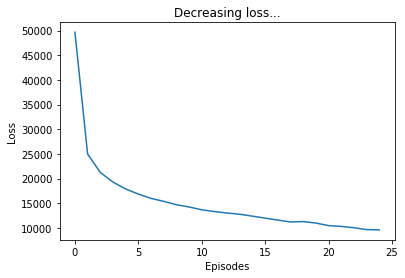

Episode: 25 
 Train Loss: 9580.775633454323 Train correct: 56542 Train Accuracy: 0.9423666666666667 
 Val Loss: 0.3097144663333893 Test Correct: 8960 Test Accuracy: 0.896


In [10]:
# Hyperparameters dictionary for grid search
test_params = dict(
    lr=[0.01, 0.001],
    batch_size=[100, 500, 1000]
)

param_values = [t for t in test_params.values()]

# Grid Search Loop
for lr,batch_size in product(*param_values): # product performs dot product between the elements contained in list
    net = Network().to(device)

    train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=batch_size
    ,shuffle=True
    )

    optimizer = optim.Adam(params=net.parameters(), lr=lr)

    comment= f"batch_size={batch_size}-lr={lr}"
    sr = SummaryWriter(comment=comment) # SummaryWriter allows the use of Tensorboard with pyTorch

    # Lists of training results
    train_losses = []
    train_corrects = []
    val_losses = []
    test_corrects = []
    
    # Training Loop
    for e in range(50):
        train_loss = 0
        val_loss = 0
        total_train_correct = 0
        total_test_correct = 0
        
        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            preds = net(images)

            loss = F.cross_entropy(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size
            total_train_correct += num_correct(preds,labels)

        with torch.no_grad():
            test_images = test_set.data.unsqueeze(dim=1)
            test_images = test_images.type(torch.FloatTensor).to(device)
            test_labels = test_set.targets.to(device)
            test_preds = net(test_images)

            val_loss = F.cross_entropy(test_preds, test_labels).item()
            total_test_correct = num_correct(test_preds,test_labels)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_corrects.append(total_train_correct)
        test_corrects.append(total_test_correct)
        
        # Appending results to TensorBoard
        sr.add_scalar("Loss", train_loss, e)
        sr.add_scalar("Val Loss", val_loss, e)
        sr.add_scalar("Train Accuracy", total_train_correct/len(train_set), e)
        sr.add_scalar("Test Accuracy", total_test_correct/len(test_set), e)

        show_loss(train_losses,val_losses,train_corrects,test_corrects,e)

#### Saving the model

In [ ]:
# torch.save(net.state_dict(), 'model.pt')

#### Loading the model

In [113]:
# net = Network().to(device)
# net.load_state_dict(torch.load('model.pt'))
# net.eval()

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

### Building the confusion matrix

In [11]:
# Dataset loader to use as
loader = torch.utils.data.DataLoader(train_set
    ,batch_size=10
    ,shuffle=False
)


with torch.no_grad():
    preds = torch.tensor([]).to(device)
    # Getting preds in batches to avoid OOM
    for batch in loader:
        images, labels = batch
        images = images.to(device)
        pred_batch = net(images)
        preds = torch.cat(
            (preds,pred_batch)
            ,dim=0)
        
preds = preds.argmax(dim=1).to(device)
targets = train_set.targets.to(device)

targets_preds = torch.stack(
    (targets,preds),
    dim=1
    ).to(device)

cm = torch.zeros([10,10],dtype=torch.int64).to(device)

# Filling in the matrix
for i in range(targets_preds.shape[0]):
    cm[targets_preds[i][0]][targets_preds[i][1]] += 1
    

#### Visualizing the matrix

In [27]:
cm

tensor([[5451,    8,   45,  101,   16,    2,  363,    0,   14,    0],
        [   4, 5951,    1,   32,    6,    0,    3,    0,    3,    0],
        [  81,    3, 4754,   45,  540,    1,  569,    0,    7,    0],
        [  59,   18,   11, 5679,  137,    0,   92,    0,    4,    0],
        [   7,    5,   62,   89, 5488,    0,  346,    0,    3,    0],
        [   3,    1,    0,    1,    0, 5724,    5,  179,   11,   76],
        [ 466,   10,  100,  103,  190,    2, 5113,    0,   16,    0],
        [   0,    0,    0,    0,    0,    4,    0, 5917,    1,   78],
        [  25,    4,   10,   14,   36,    4,   57,    9, 5839,    2],
        [   0,    0,    0,    0,    0,    4,    0,  120,    1, 5875]], device='cuda:0')

#### Confusion Matrix as Heat Map

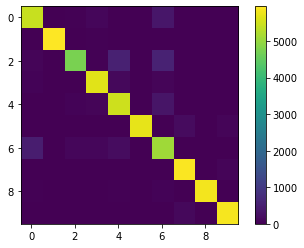

In [28]:
plt.imshow(cm.tolist(), interpolation='nearest' ,cmap="viridis");
plt.colorbar()
plt.show()